In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import cv2
import imageio
import datetime

sys.path.append('../deepcell')

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import Input, Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Layer, Dense, BatchNormalization, Activation, Softmax

# from scipy.stats import mode
from einops import rearrange, repeat

# from skimage.measure import regionprops, regionprops_table

# from sklearn import metrics as sk_metrics

In [3]:
from deepcell.mibi_data_help import create_cell_tf_dataset
from deepcell.graph_utils import load_mibi_data, get_marker_dict, load_celltypes, get_max_cells

In [4]:
%%time

# data_path = 'D:/GNN/data/TNBC'
data_path = '../data/TNBC/'

mibi_data_path = os.path.join(data_path, 'TNBCShareData')
mibi_label_path = os.path.join(data_path, 'TNBC_labels/label_images.npy')
mibi_celltype_path = os.path.join(data_path, 'TNBCcellTypes')
TNBCpanelInfo_path = os.path.join(data_path,'TNBCpanelInfo.csv')

# print(mibi_data_path)

POINT_LIST = [2, 5, 8, 9, 21, 22, 24, 26, 34, 37, 38, 41]

mibi_data = load_mibi_data(mibi_data_path, point_list=POINT_LIST)
mibi_labels = np.load(mibi_label_path)
mibi_celltypes = load_celltypes(mibi_celltype_path, point_list=POINT_LIST)

# cell type label codes
"""
  % 0 - background ; 1- Negative ; 2- Endothel ; 3- Mesenchyme ;
  % 4- Tumor ; 5- Immune: Tregs ; 6- Immune: CD4 T ; 7- Immune CD8 T ; 8-
  % Immune CD3 T ; 9- Immune: NK ; 10- Immune: B ; 11- Immune:
  % Neutrophiles ; 12- Immune: Macrophages ; 13- Immune: DC ; 14- Immune:
  % DC/Mono ; 15- Immune: Mono/Neu ; 16: Immune: Other

"""

## created a dictionary of cell types 
celltype_label_dict = {0:'background', 1:'Negative', 2:'Endothel', 3:'Mesenchyme',
                       4:'Tumor', 5:'Tregs', 6:'CD4 T', 7:'CD8 T', 8:'CD3 T',
                       9:'Nk', 10:'B', 11:'Neutrophiles', 12:'Macrophages',
                       13:'DC', 14: 'DC_Mono', 15:'Mono_Neu', 16:'Other'}


# get good channels that were used in original clustering
TNBCpanelInfo = pd.read_csv(TNBCpanelInfo_path)
good_markers = TNBCpanelInfo[TNBCpanelInfo['Used for clustering'] == 1]['Label'].to_list()
marker_dict = get_marker_dict(os.path.join(mibi_data_path,'Point1'))#, index=True)
marker_idxs = list(map(marker_dict.get, good_markers))

# num of features = # of good markers
num_features = len(good_markers)

# create a look up table to go from index to maker name
marker_idx_dict = dict(zip(list(range(len(good_markers))),good_markers))

# Shrink raw data and labelsa to line up with cell type image
tmp_mibi_data = mibi_data[:,30:-30, 30:-30, marker_idxs]
mibi_labels = mibi_labels[:,30:-30, 30:-30, :]
mibi_celltypes = mibi_celltypes[:,30:-30, 30:-30, :]

CPU times: user 27.6 s, sys: 3.58 s, total: 31.2 s
Wall time: 31.3 s


In [6]:
%%time
from deepcell.mibi_data_help import create_cell_tf_dataset

train_dataset, val_dataset = create_cell_tf_dataset(tmp_mibi_data, 
                                                    mibi_labels, 
                                                    mibi_celltypes, 
                                                    marker_idx_dict,
                                                    mode = 'GCN',
                                                    reshape=True)

Reshaped feature data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped training data from (10, 1988, 1988, 23) to (160, 512, 512, 23)
Reshaped feature data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped training data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped feature data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
Reshaped training data from (2, 1988, 1988, 23) to (32, 512, 512, 23)
Reshaped feature data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
Reshaped training data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
CPU times: user 3min 7s, sys: 1min 5s, total: 4min 12s
Wall time: 2min 58s


In [7]:
BATCH_SIZE = 10

train = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE)
val = val_dataset.shuffle(len(val_dataset)).batch(BATCH_SIZE)

#get class names from val data
true_label_data = np.concatenate([y['celltypes'] for x, y in val])
true_label_data = true_label_data.reshape(true_label_data.shape[0]*true_label_data.shape[1], -1)
true_label = np.argmax(true_label_data, axis=1)
class_names = list(map(celltype_label_dict.__getitem__, set(true_label)))

In [8]:
from spektral.layers import GraphConv


# n_nodes = CTD_graph_train_small.feature_matrix.shape[1]

def graphconv_model(feature_shape=(None,num_features),
                    adj_shape=(None,None)):
    x_in = Input(shape=feature_shape, name='feature_matrix')
    a_in = Input(shape=adj_shape, name='adjacency_matrix')
    
    x = x_in
    for i in range(2):
        x = GraphConv(128)([x, a_in])
        x = BatchNormalization(axis=-1)(x)
        x = Activation('relu')(x)
    x = Dense(17)(x)
    x = Softmax(axis=-1, name='celltypes')(x)
    return Model(inputs=[x_in, a_in], outputs=x)

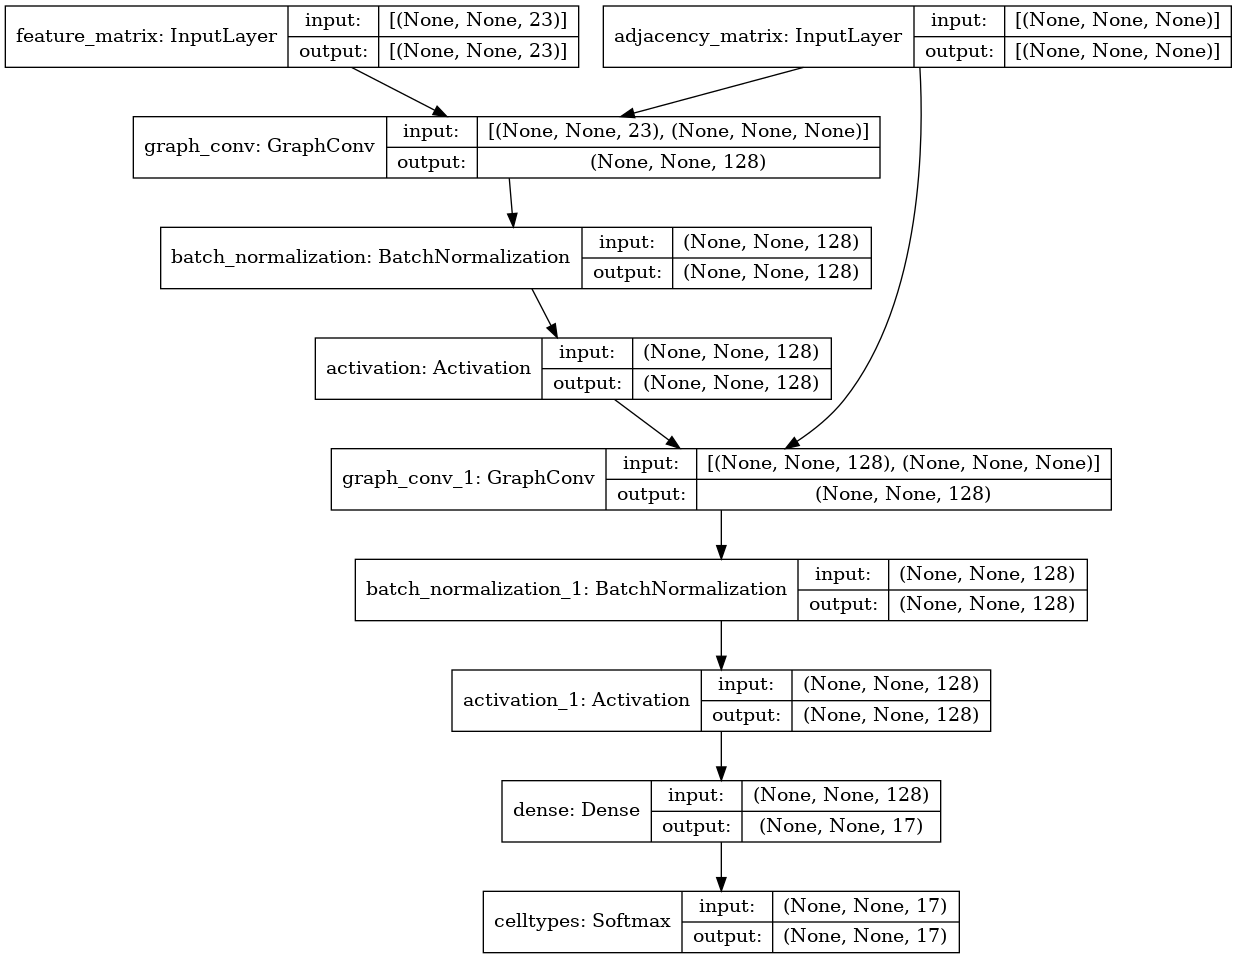

In [9]:
model = graphconv_model()
plot_model(model, show_shapes=True)

In [10]:
model_type = "small_img_graph-"
log_dir = "logs/"+ model_type + datetime.datetime.now().strftime("%Y_%m_%d-%H%M%S")

# define basic TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

optimizer = Adam(learning_rate=1e-3)
losses = {'celltypes': tf.keras.losses.CategoricalCrossentropy()}
metrics = {'celltypes': ['accuracy', 'Precision', 'Recall']}
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

model.fit(train,
          batch_size=BATCH_SIZE,
          epochs=64,
          validation_data=val,
          callbacks=[tensorboard_callback])

Epoch 1/64
16/16 [==============================] - 2s 57ms/step - loss: 2.5310 - accuracy: 0.4034 - precision: 0.4526 - recall: 0.0809 - val_loss: 2.6469 - val_accuracy: 0.6324 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/64
16/16 [==============================] - 0s 17ms/step - loss: 0.8942 - accuracy: 0.7980 - precision: 0.9607 - recall: 0.6651 - val_loss: 2.4944 - val_accuracy: 0.6241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/64
16/16 [==============================] - 0s 11ms/step - loss: 0.6299 - accuracy: 0.8372 - precision: 0.9541 - recall: 0.7480 - val_loss: 2.3976 - val_accuracy: 0.4018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/64
16/16 [==============================] - 0s 11ms/step - loss: 0.6145 - accuracy: 0.8308 - precision: 0.9307 - recall: 0.7564 - val_loss: 2.3319 - val_accuracy: 0.2579 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/64
16/16 [==============================] - 0s 11ms/step - loss: 0.5

In [11]:
%load_ext tensorboard
%tensorboard --logdir logs --host=0.0.0.0

## Equivariant Graph Conv

In [73]:
%%time
from deepcell.mibi_data_help import create_cell_tf_dataset

train_dataset, val_dataset = create_cell_tf_dataset(tmp_mibi_data, 
                                                    mibi_labels, 
                                                    mibi_celltypes, 
                                                    marker_idx_dict,
                                                    mode = 'EGCL',
                                                    reshape=True)

Reshaped feature data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped training data from (10, 1988, 1988, 23) to (160, 512, 512, 23)
Reshaped feature data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped training data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped feature data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
Reshaped training data from (2, 1988, 1988, 23) to (32, 512, 512, 23)
Reshaped feature data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
Reshaped training data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
CPU times: user 3min 10s, sys: 1min 13s, total: 4min 23s
Wall time: 2min 59s


In [74]:
BATCH_SIZE = 10

train = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE)
val = val_dataset.shuffle(len(val_dataset)).batch(BATCH_SIZE)

#get class names from val data
true_label_data = np.concatenate([y['celltypes'] for x, y in val])
true_label_data = true_label_data.reshape(true_label_data.shape[0]*true_label_data.shape[1], -1)
true_label = np.argmax(true_label_data, axis=1)
class_names = list(map(celltype_label_dict.__getitem__, set(true_label)))

In [75]:
train

<BatchDataset shapes: ({feature_matrix: (None, 383, 23), adjacency_matrix: (None, 383, 383), coords: (None, 383, 2)}, {celltypes: (None, 383, 17)}), types: ({feature_matrix: tf.float32, adjacency_matrix: tf.float64, coords: tf.float64}, {celltypes: tf.float32})>

In [76]:
val

<BatchDataset shapes: ({feature_matrix: (None, 383, 23), adjacency_matrix: (None, 383, 383), coords: (None, 383, 2)}, {celltypes: (None, 383, 17)}), types: ({feature_matrix: tf.float32, adjacency_matrix: tf.float64, coords: tf.float64}, {celltypes: tf.float32})>

In [77]:
class EGCL(Layer):
    def __init__(self, dim, **kwargs):
        super(EGCL, self).__init__(**kwargs)
        
        # edge_input_dim = dim*2 + edge_dim + 1
        
        self.edge_func = tf.keras.Sequential([Dense(64),
                                              Activation('swish'),
                                              Dense(64),
                                              Activation('swish')
                                              ])
        
        self.coord_func = tf.keras.Sequential([Dense(64),
                                               Activation('swish'),
                                               Dense(1)
                                              ])
        
        self.node_func = tf.keras.Sequential([Dense(64),
                                              Activation('swish'),
                                              Dense(23)
                                             ])
        
        
    def call(self, x):
        coords = x[0]
        feats = x[1]
        edges = x[2]
        
#         edges = None
        
        b, n, d = feats.shape # (batch, n_nodes, n_feats)
        
        # rel_coords = (batch, n_nodes, n_nodes, n_coords)
        rel_coords = rearrange(coords, 'b i d -> b i () d') - rearrange(coords, 'b  j d -> b () j d')
        # rel_dist = (batch, n_nodes, n_nodes, 1)
        rel_dist = tf.reduce_sum((rel_coords ** 2), axis=-1, keepdims=True)
        
        feats_i = repeat(feats, 'b i d -> b i n d', n=n) #n = n_nodes
        feats_j = repeat(feats, 'b j d -> b n j d', n=n) #n = n_nodes
        
        # edge_input = (batch, n_nodes, n_nodes, (2*n_feats + 1))
        edge_input = tf.concat([feats_i, feats_j, rel_dist], axis=-1)
        
        if edges is not None:
            edges = tf.expand_dims(edges, axis=-1) # (batch, n_nodes, n_nodes, 1)
            
            # edge_input = (batch, n_nodes, n_nodes, (2*n_feats + 2))
            edge_input = tf.concat([edge_input, edges], axis=-1)

        
        m_ij = self.edge_func(edge_input)
        
        coord_weights = self.coord_func(m_ij)
        coord_weights = rearrange(coord_weights, 'b i j () -> b i j')
        
        coords_out = tf.einsum('b i j, b i j c -> b i c', coord_weights, rel_coords) + coords
        
        m_i = tf.reduce_sum(m_ij, axis=-2)
        
        node_input = tf.concat([feats, m_i], axis=-1)
        node_out = self.node_func(node_input) + feats
        
        return coords_out, node_out

In [84]:
n_nodes = 383
batch_size = 10

def egnn_model():
    adj = Input(shape=(n_nodes, n_nodes), name='adjacency_matrix')
    coords = Input(shape=(n_nodes, 2), name='coords')
    feats = Input(shape=(n_nodes,23), name='feature_matrix')
    
    x, h = EGCL(64)([coords, feats, adj])
    
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    h = BatchNormalization(axis=-1)(h)
    h = Activation('relu')(h)
    
    x, h = EGCL(64)([x, h, adj])
    h = Activation('relu')(h)
    
#     out = tf.keras.layers.Flatten()(x)
    out = Dense(17)(h)
    out = Softmax(axis=-1, name='celltypes')(out)
    
    return Model(inputs=[coords, feats, adj], outputs=out)

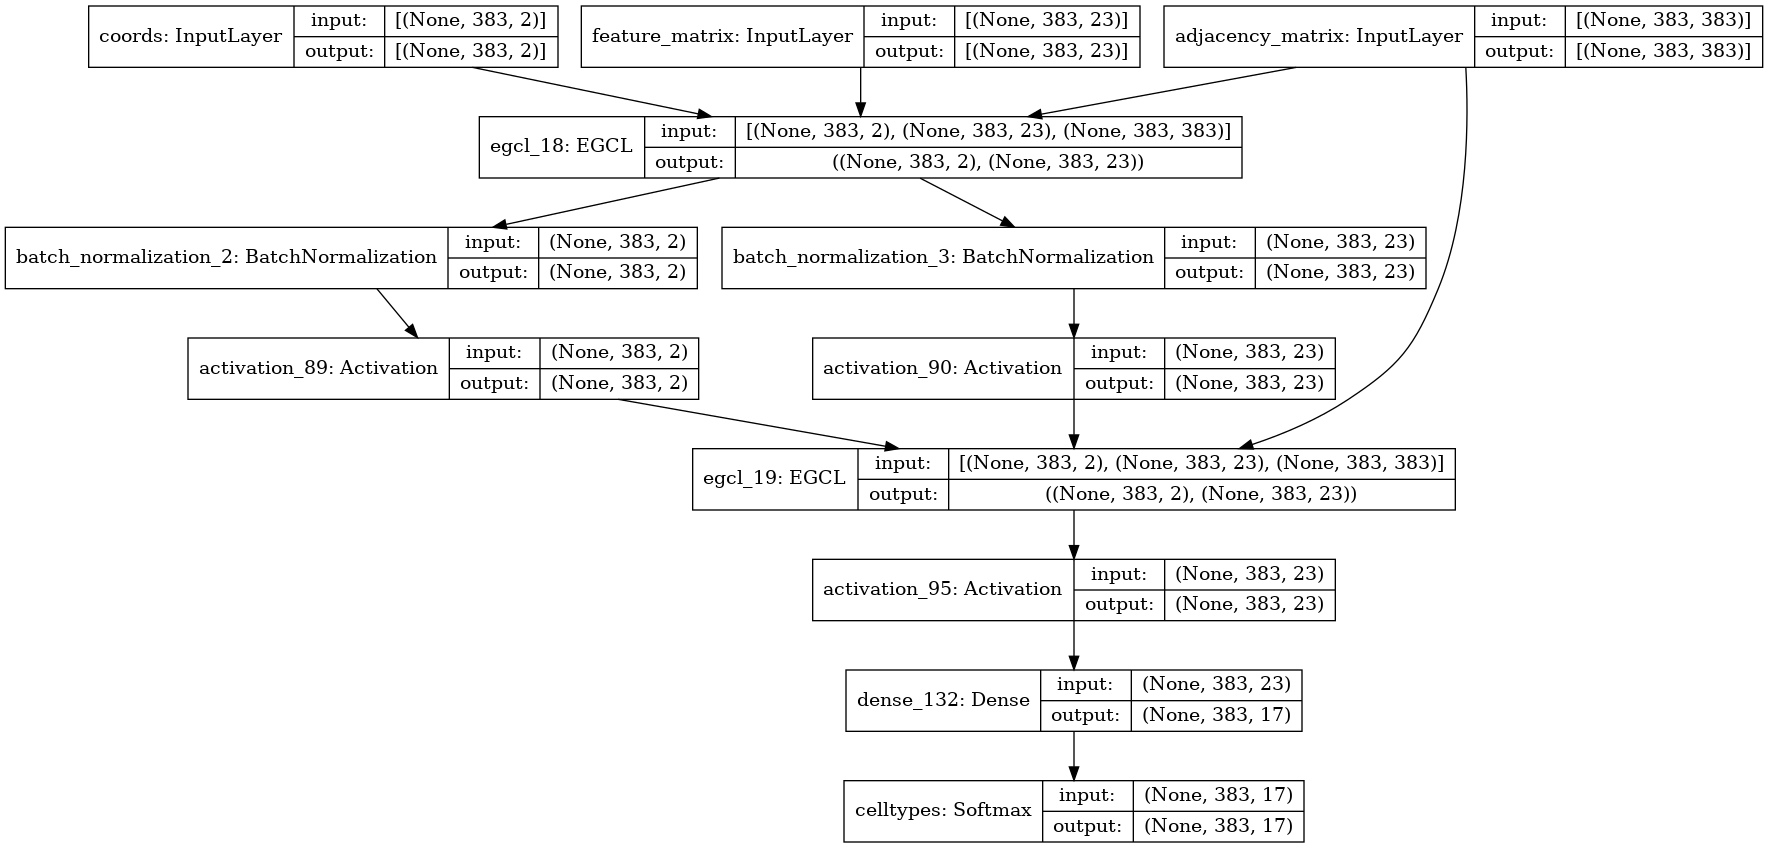

In [85]:
model = egnn_model()
plot_model(model, show_shapes=True)

In [86]:
logdir = os.path.join("logs", 'egcl')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

optimizer = Adam(learning_rate=1e-3)
losses = {'celltypes': tf.keras.losses.CategoricalCrossentropy()}
metrics = {'celltypes': ['accuracy', 'Precision', 'Recall']}
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

# dg = DataGenerator(n_nodes, batch_size=batch_size, steps_per_epoch=128)

model.fit(train,
          batch_size=BATCH_SIZE,
          epochs=64,
          validation_data=val,
          callbacks=[tensorboard_callback])

Epoch 1/64
16/16 [==============================] - 9s 487ms/step - loss: 10.1953 - accuracy: 0.3981 - precision: 0.4105 - recall: 0.3943 - val_loss: 117.3548 - val_accuracy: 0.0461 - val_precision: 0.0461 - val_recall: 0.0461
Epoch 2/64
16/16 [==============================] - 7s 413ms/step - loss: 5.9483 - accuracy: 0.5149 - precision: 0.5234 - recall: 0.5079 - val_loss: 151.1952 - val_accuracy: 0.1055 - val_precision: 0.1055 - val_recall: 0.1055
Epoch 3/64
16/16 [==============================] - 7s 411ms/step - loss: 5.2007 - accuracy: 0.4759 - precision: 0.4951 - recall: 0.4647 - val_loss: 111.3610 - val_accuracy: 0.1475 - val_precision: 0.1475 - val_recall: 0.1475
Epoch 4/64
16/16 [==============================] - 7s 411ms/step - loss: 2.5856 - accuracy: 0.5761 - precision: 0.6329 - recall: 0.4748 - val_loss: 46.5527 - val_accuracy: 0.1274 - val_precision: 0.1273 - val_recall: 0.1271
Epoch 5/64
16/16 [==============================] - 7s 412ms/step - loss: 1.8725 - accuracy: 0.6

In [87]:
%load_ext tensorboard
%tensorboard --logdir logs --host=0.0.0.0

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
